In [1]:
import json
import sys
from os import listdir
from os.path import isfile, join
import re
import string
import pandas as pd
import numpy as np

import time
from tqdm import tqdm
from typing import List

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
# from keras.preprocessing.sequence import pad_sequences

import transformers
from transformers import AutoTokenizer, AutoModel, utils
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, TrainingArguments
from datasets import Dataset
transformers.logging.set_verbosity_error()
utils.logging.set_verbosity_error()  # Suppress standard warnings

from bertviz import model_view, head_view


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import eli5
from eli5.lime import TextExplainer
# from captum.attr import IntegratedGradients
# import matplotlib.pyplot as plt


from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

## Data

In [2]:
sen_train_data = pd.read_csv('train_sentence_data.csv')
sen_test_data = pd.read_csv('test_sentence_data.csv')
sen_val_data = pd.read_csv('val_sentence_data.csv')

In [3]:
sen_train_data = sen_train_data.drop(['File_id'],axis=1)
sen_test_data = sen_test_data.drop(['File_id'],axis=1)
sen_val_data = sen_val_data.drop(['File_id'],axis=1)

In [4]:
def get_20(data):
    data_1 = data.loc[data['Status'] ==1].iloc[:20]
    data_2 = data.loc[data['Status'] ==0].iloc[:20]
    frames = [data_1, data_2]
    return pd.concat(frames)

sen_train_data = get_20(sen_train_data) 
sen_test_data = get_20(sen_test_data)
sen_val_data = get_20(sen_val_data)

In [5]:
sen_train_data=sen_train_data.sample(frac = 1)
sen_test_data=sen_test_data.sample(frac = 1)
sen_val_data=sen_val_data.sample(frac = 1)

In [6]:
sen_train_data.to_csv('Train_auto.csv',index=False)
sen_test_data.to_csv('Test_auto.csv',index=False)
sen_val_data.to_csv('val_auto.csv',index=False)

In [7]:
sen_train_data.Status.value_counts()

1    20
0    20
Name: Status, dtype: int64

In [8]:
# Load train and validation datasets from CSV files
train_dataset = Dataset.from_csv('Train_auto.csv')
val_dataset = Dataset.from_csv('val_auto.csv')
test_dataset = Dataset.from_csv('Test_auto.csv')

# Rename the columns to 'text' and 'label' to match the expected format for sequence classification
train_dataset = train_dataset.rename_column('Sentence', 'text').rename_column('Status', 'label')
val_dataset = val_dataset.rename_column('Sentence', 'text').rename_column('Status', 'label')
test_dataset = test_dataset.rename_column('Sentence', 'text').rename_column('Status', 'label')


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/admin/.cache/huggingface/datasets/csv/default-06aa0b25082cbea4/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/admin/.cache/huggingface/datasets/csv/default-1fee19994071e886/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/admin/.cache/huggingface/datasets/csv/default-028d073ee69402aa/0.0.0. Subsequent calls will reuse this data.


In [9]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

# Define a function to tokenize the text and create input sequences
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True,max_length=512)

# Apply the tokenization function to the train and validation datasets
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
val_dataset = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [10]:
model = AutoModelForSequenceClassification.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens', num_labels=2)

In [11]:
# Train the model
training_args = TrainingArguments(
    output_dir='./results/bert',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [12]:
trainer = Trainer(
    model=model,                     # the instantiated Transformers model to be trained
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,     # training dataset
    eval_dataset=val_dataset,        # evaluation dataset
)
trainer.train()

/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'train_runtime': 57.4374, 'train_samples_per_second': 2.089, 'train_steps_per_second': 0.157, 'train_loss': 0.7604381773206923, 'epoch': 3.0}


TrainOutput(global_step=9, training_loss=0.7604381773206923, metrics={'train_runtime': 57.4374, 'train_samples_per_second': 2.089, 'train_steps_per_second': 0.157, 'train_loss': 0.7604381773206923, 'epoch': 3.0})

In [13]:
# Evaluate the model
eval_results = trainer.evaluate(test_dataset)
print(eval_results)

{'eval_loss': 0.7438465356826782, 'eval_runtime': 5.761, 'eval_samples_per_second': 6.943, 'eval_steps_per_second': 0.174, 'epoch': 3.0}
{'eval_loss': 0.7438465356826782, 'eval_runtime': 5.761, 'eval_samples_per_second': 6.943, 'eval_steps_per_second': 0.174, 'epoch': 3.0}


In [14]:
def model_adapter(texts: List[str]):
    
    all_scores = []

    for i in tqdm(range(0, len(texts), 64)):

        batch = texts[i:i+64]
        #print(batch)
        
        # use bert encoder to tokenize text 
        encoded_input = tokenizer(batch, 
          return_tensors='pt', 
          padding=True, 
          truncation=True, 
          max_length=model.config.max_position_embeddings-2)

        # run the model
        output = model(**encoded_input)
        #print(output)
        # by default this model gives raw logits rather 
        # than a nice smooth softmax so we apply it ourselves here
        scores = output[0].softmax(1).detach().numpy()
        #print(scores)

        all_scores.extend(scores)

    return np.array(all_scores)

In [15]:
sen = sen_test_data.Sentence
lab = sen_test_data.Status

In [16]:
specter_exp = TextExplainer(n_samples=5000, random_state=42)
specter_exp.fit(sen[0], model_adapter)
specter_exp.explain_prediction(target_names=list(model.config.id2label.values()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [03:17<00:00,  2.50s/it]
/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Explanation(estimator="SGDClassifier(alpha=0.001, loss='log', penalty='elasticnet',\n              random_state=RandomState(MT19937) at 0x7F8566C5BEB8)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='LABEL_0', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='a challenging', weight=0.4152514386891713, std=None, value=1.0), FeatureWeight(feature='challenging', weight=0.4027574644577268, std=None, value=1.0), FeatureWeight(feature='challenging task', weight=0.2304663286695488, std=None, value=1.0), FeatureWeight(feature='is', weight=0.2229318398797763, std=None, value=1.0), FeatureWeight(feature='to synthesize', weight=0.2133829438948253, std=None, value=1.0), FeatureWeight(feature='of examples', weight=0.2037769157041851, std=None, value=1.0), FeatureWeight(feature='small number', weight=0.20035728304628836, std=None, value=1.0), FeatureWeight(feature='neural', weight=0.16975270205003937, std=None, value=1.0), FeatureWeight(feature='examples is', weight=0.12653913157572264, std=None, value=1.0), FeatureWeight(feature='from a', weight=0.12571967000933104, std=None, value=1.0), FeatureWeight(feature='a small', weight=0.12330701761759455, std=None, value=1.0), FeatureWeight(feature='robust programs', weight=0.10602952922289487, std=None, value=1.0), FeatureWeight(feature='is a', weight=0.10114553980830655, std=None, value=1.0), FeatureWeight(feature='small', weight=0.09335172607586029, std=None, value=1.0), FeatureWeight(feature='networks to', weight=0.06092254827869191, std=None, value=1.0), FeatureWeight(feature='number of', weight=0.05679959993591098, std=None, value=1.0)], neg=[FeatureWeight(feature='<BIAS>', weight=-0.4250196011744657, std=None, value=1.0), FeatureWeight(feature='a', weight=-0.3039034752436394, std=None, value=2.0), FeatureWeight(feature='of', weight=-0.23343886881945974, std=None, value=1.0), FeatureWeight(feature='training', weight=-0.20525086894181716, std=None, value=1.0), FeatureWeight(feature='from', weight=-0.1544977138310304, std=None, value=1.0), FeatureWeight(feature='to', weight=-0.14639204062531747, std=None, value=1.0), FeatureWeight(feature='examples', weight=-0.12476100554182291, std=None, value=1.0), FeatureWeight(feature='task', weight=-0.1075058961280444, std=None, value=1.0), FeatureWeight(feature='synthesize', weight=-0.09658417180778676, std=None, value=1.0), FeatureWeight(feature='number', weight=-0.05164980094034648, std=None, value=1.0), FeatureWeight(feature='programs', weight=-0.016115236579685603, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.7285687283603709, score=-0.9873729992824581, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='training neural networks to synthesize robust programs from a small number of examples is a challenging task', spans=[('training', [(0, 8)], -0.20525086894181716), ('neural', [(9, 15)], 0.16975270205003937), ('to', [(25, 27)], -0.14639204062531747), ('synthesize', [(28, 38)], -0.09658417180778676), ('programs', [(46, 54)], -0.016115236579685603), ('from', [(55, 59)], -0.1544977138310304), ('a', [(60, 61)], -0.3039034752436394), ('small', [(62, 67)], 0.09335172607586029), ('number', [(68, 74)], -0.05164980094034648), ('of', [(75, 77)], -0.23343886881945974), ('examples', [(78, 86)], -0.12476100554182291), ('is', [(87, 89)], 0.2229318398797763), ('a', [(90, 91)], -0.3039034752436394), ('challenging', [(92, 103)], 0.4027574644577268), ('task', [(104, 108)], -0.1075058961280444), ('networks to', [(16, 24), (25, 27)], 0.06092254827869191), ('to synthesize', [(25, 27), (28, 38)], 0.2133829438948253), ('robust programs', [(39, 45), (46, 54)], 0.10602952922289487), ('from a', [(55, 59), (60, 61)], 0.12571967000933104), ('a small', [(60, 61), (62, 67)], 0.12330701761759455), ('small number', [(62, 67), (68, 74)], 0.20035728304628836), ('number of', [(68, 74), (75, 77)], 0.05679959993591098), ('of examples', [(75, 77), (78, 86)], 0.203776915704

/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


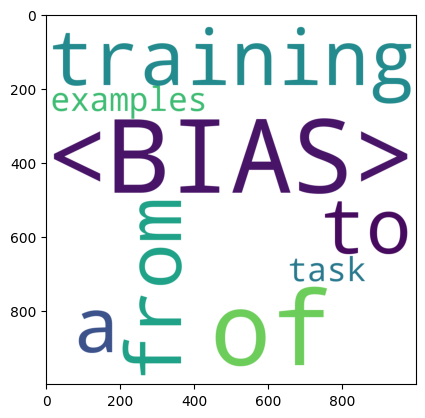

In [17]:
weights = specter_exp.explain_weights()

sen_positivie_words= {}

for i in weights.targets[0].feature_weights.pos:
    #print(i.feature)
    g = sen_positivie_words.get(i.feature,-1)
    if g==-1:
        sen_positivie_words[i.feature]=1
    else:
        sen_positivie_words[i.feature]+=1
        

sen_negative_words= {}

for i in weights.targets[0].feature_weights.neg:
    #print(i.feature)
    g = sen_negative_words.get(i.feature,-1)
    if g==-1:
        sen_negative_words[i.feature]=1
    else:
        sen_negative_words[i.feature]+=1

        
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(sen_positivie_words)
plt.imshow(wc)


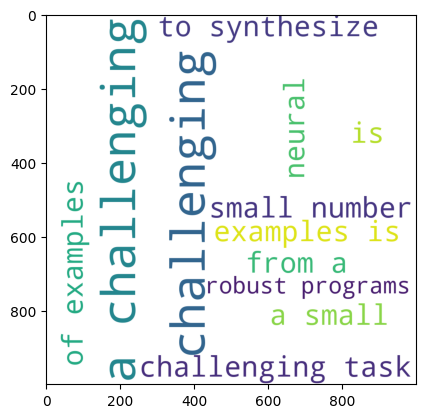

In [18]:
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(sen_negative_words)
plt.imshow(wc)

## very inportant

In [19]:
# print(weights.targets[0].feature_weights.pos[0].weight,weights.targets[0].feature_weights.pos[0].feature)

In [20]:
# d = specter_exp.explain_prediction()

### Logistic Regression

In [21]:
doc_train_data = pd.read_csv("./complete_sentence/train_processed_data.csv")
doc_test_data = pd.read_csv("./complete_sentence/train_processed_data.csv") 

In [22]:
doc_train_data = get_20(doc_train_data)
doc_test_data = get_20(doc_test_data)

In [23]:
doc_train_data.head()

,File_id,Paper_text,Status
0,304.pdf.json,training neural networks to synthesize robust ...,1
1,305.pdf.json,data compression is a fundamental and well-stu...,1
2,306.pdf.json,deep learning has shown great success in a var...,1
3,307.pdf.json,the most useful applications of dialog systems...,1
4,308.pdf.json,generative adversarial networks (gans)(goodfel...,1


In [24]:
doc_train_text = doc_train_data.Paper_text.values.tolist()
doc_train_status = doc_train_data.Status.values.tolist()

doc_test_text = doc_test_data.Paper_text.values.tolist()
doc_test_status = doc_test_data.Status.values.tolist()

In [25]:
class Padding(BaseEstimator, TransformerMixin):
    
    def __init__(self,model,tokenizer):
        self.model = model # Configure model to return attention values
        self.tokenizer = tokenizer
        self.mxlenght = 400
        print('\n>>>>>>>init() called.\n')

    def fit(self, X, y = None):
        print('\n>>>>>>>fit() called.\n')
        return self
    

    def transform(self, X, y = None):
        embeddings = []
        for i in tqdm(X):
            temp = [] 
            sentence_list = i.split(".")
            for i in sentence_list:
                if len(i)==0:
                    continue
                encoded_input = self.tokenizer(i,return_tensors='pt', padding=True, truncation=True,max_length=model.config.max_position_embeddings-2)
                output = self.model(**encoded_input)
                pred = np.argmax(output[0].softmax(1).detach().numpy())
                temp.append(pred)
            size = self.mxlenght - len(temp)
            if size > 0:
                temp.extend([-1]*size)
            elif size < 0:
                temp = temp[0:self.mxlenght]
            else:
                pass
            embeddings.append(temp)
        return embeddings

In [26]:
pipe1 = Pipeline(steps=[
                       ('Documnet Embeddings', Padding(model,tokenizer)), # this will trigger a call to __init__
                       ('Logistic Regression', LogisticRegression(solver='lbfgs')),

])

pipe1.fit(doc_train_text, doc_train_status)
pipe1.score(doc_test_text,doc_test_status)


>>>>>>>init() called.


>>>>>>>fit() called.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [1:12:15<00:00, 108.39s/it]


1.0

In [27]:
target =['Reject','Accept']
doc = doc_test_text[0]
pipe1_exp = TextExplainer(n_samples=10,random_state=42)
pipe1_exp.fit(doc, pipe1.predict_proba)
pipe1_exp.show_prediction(target_names= target)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:15<00:00, 61.57s/it]
/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
weights = pipe1_exp.explain_weights(top= None)
positivie_words= {}

for i in weights.targets[0].feature_weights.pos:
    #print(i.feature)
    g = positivie_words.get(i.feature,-1)
    if g==-1:
        positivie_words[i.feature]=1
    else:
        positivie_words[i.feature]+=1
        

negative_words= {}

for i in weights.targets[0].feature_weights.neg:
    #print(i.feature)
    g = negative_words.get(i.feature,-1)
    if g==-1:
        negative_words[i.feature]=1
    else:
        negative_words[i.feature]+=1
# print(weights.targets[0].feature_weights.pos[0].weight,weights.targets[0].feature_weights.pos[0].feature)

/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


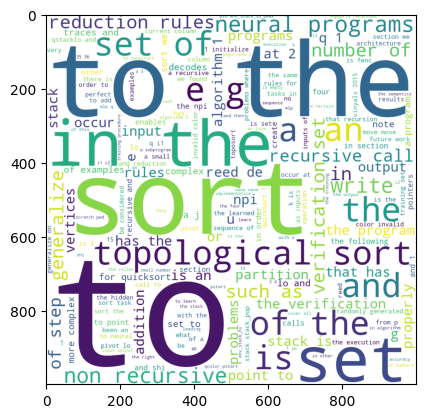

In [29]:
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(positivie_words)
plt.imshow(wc)

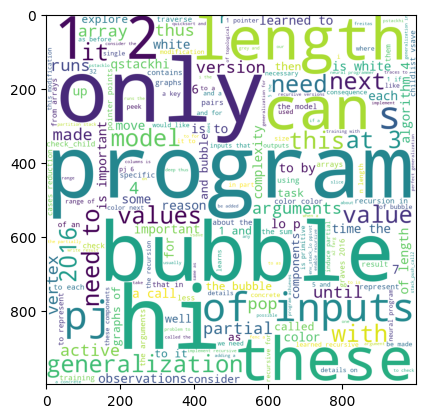

In [30]:
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(negative_words)
plt.imshow(wc)

In [31]:
def print_prediction(doc):
    #print(doc)
    y_pred = pipe1.predict_proba([doc])[0]
    tar =['Reject','Accept']
    for target, prob in zip(tar, y_pred):
        print("{:.3f} {}".format(prob, target))

In [33]:
print_prediction(doc_test_text[0])

training neural networks to synthesize robust programs from a small number of examples is a challenging task. the space of possible programs is extremely large, and composing a program that performs robustly on the infinite space of possible inputs is difficult—in part because it is impractical to obtain enough training examples to easily disambiguate amongst all possible programs. nevertheless, we would like the model to quickly learn to represent the right semantics of the underlying program from a small number of training examples, not an exhaustive number of them.
thus far, to evaluate the efficacy of neural models on programming tasks, the only metric that has been used is generalization of expected behavior to inputs of greater complexity (vinyals   (2015), kaiser & sutskever (2015), reed & de freitas (2016), graves   (2016), zaremba   (2016)). for example, for the addition task, the model is trained on short inputs and then tested on its ability to sum inputs with much longer nu

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:57<00:00, 57.75s/it]

0.038 Reject
0.962 Accept


## SVM CLASSIFIER

In [68]:
class CustomEmbedding(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.model_name = "sentence-transformers/bert-base-nli-mean-tokens"
        self.model = AutoModel.from_pretrained(self.model_name, output_attentions=True)  # Configure model to return attention values
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        print('\n>>>>>>>init() called.\n')

    def fit(self, X, y = None):
        print('\n>>>>>>>fit() called.\n')
        return self
    
    def mean_pooling(self,model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


    def bert(self,text):
        encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        inputs = self.tokenizer.encode(text, return_tensors='pt',max_length=self.model.config.max_position_embeddings-2)  # Tokenize input text

        outputs = self.model(inputs)  # Run model
        attention = outputs[-1]  # Retrieve attention from model outputs

        tokens = self.tokenizer.convert_ids_to_tokens(inputs[0]) 
        sentence_embeddings = self.mean_pooling(outputs, encoded_input['attention_mask'])
        return sentence_embeddings.detach().numpy()[0].tolist()

    def transform(self, X, y = None):
        embeddings = []
        for i in X:
            emb = self.bert(i)
            embeddings.append(emb)
        #print(embeddings)
        return embeddings
        

In [69]:
pipe2 = Pipeline(steps=[
                       ('Bert Embeddings', CustomEmbedding()),    # this will trigger a call to __init__
                       ('Support Vector Classifier', SVC(kernel='rbf',probability=True))
])



>>>>>>>init() called.



In [70]:
sen_text = sen_train_data['Sentence']
sen_label = sen_train_data['Status']
pipe2.fit(sen_text, sen_label)


>>>>>>>fit() called.



Pipeline(steps=[('Bert Embeddings', CustomEmbedding()),
                ('Support Vector Classifier', SVC(probability=True))])

In [71]:
sen_test_text = sen_test_data['Sentence']
sen_test_lab = sen_test_data['Status']
pipe2.score(sen_test_text,sen_test_lab)

0.5

In [72]:
target =['Reject','Accept']
doc = 'however, models that make use of this strategy eventually fail after a certain level of complexity (e'
pipe2_exp = TextExplainer(random_state=42)
pipe2_exp.fit(doc, pipe2.predict_proba)
pipe2_exp.show_prediction(target_names= target)

KeyboardInterrupt: 

In [ ]:
def print_prediction_1(doc):
    print(doc)
    y_pred = pipe2.predict_proba([doc])[0]
    tar =['Reject','Accept']
    for target, prob in zip(tar, y_pred):
        print("{:.3f} {}".format(prob, target))

In [ ]:
pipe2_exp.explain_weights(target_names=target)

In [65]:
print(pipe2.classes_) 
print(pipe2_exp.metrics_ )

[0 1]
{'mean_KL_divergence': 0.001366513088187958, 'score': 1.0}


In [66]:
class Padding_2(BaseEstimator, TransformerMixin):
    
    def __init__(self,pipe):
        self.model = pipe # Configure model to return attention values
        self.tokenizer = tokenizer
        self.mxlenght = 400
        print('\n>>>>>>>init() called.\n')

    def fit(self, X, y = None):
        print('\n>>>>>>>fit() called.\n')
        return self
    

    def transform(self, X, y = None):
        embeddings = []
        for i in tqdm(X):
            temp = [] 
            sentence_list = i.split(".")
            for i in sentence_list:
                if len(i)==0:
                    continue
                pred = self.model.predict([i])
                temp.append(pred[0])
            size = self.mxlenght - len(temp)
            if size > 0:
                temp.extend([-1]*size)
            elif size < 0:
                temp = temp[0:self.mxlenght]
            else:
                pass
            embeddings.append(temp)
        return embeddings

In [67]:
pipe3 = Pipeline(steps=[
                       ('Documnet Embeddings', Padding_2(pipe2)), # this will trigger a call to __init__
                       ('Logistic Regression', LogisticRegression(solver='lbfgs')),

])

pipe3.fit(doc_train_text, doc_train_status)
pipe3.score(doc_test_text,doc_test_status)


>>>>>>>init() called.


>>>>>>>fit() called.



  0%|                                                                                                               | 0/40 [00:47<?, ?it/s]


RuntimeError: The expanded size of the tensor (510) must match the existing size (824) at non-singleton dimension 1.  Target sizes: [1, 510, 768].  Tensor sizes: [1, 824, 1]

In [ ]:
def print_prediction_2(doc):
    print(doc)
    y_pred = pipe3.predict_proba([doc])[0]
    tar =['Reject','Accept']
    for target, prob in zip(tar, y_pred):
        print("{:.3f} {}".format(prob, target))

In [ ]:
target =['Reject','Accept']
doc = text[0]
pipe3_exp = TextExplainer(random_state=42)
pipe3_exp.fit(doc, pipe3.predict_proba)
pipe3_exp.show_prediction(target_names= target)

In [ ]:
weights = pipe3_exp.explain_weights(top= None)
positivie_words= {}

for i in weights.targets[0].feature_weights.pos:
    #print(i.feature)
    g = positivie_words.get(i.feature,-1)
    if g==-1:
        positivie_words[i.feature]=1
    else:
        positivie_words[i.feature]+=1
        

negative_words= {}

for i in weights.targets[0].feature_weights.neg:
    #print(i.feature)
    g = negative_words.get(i.feature,-1)
    if g==-1:
        negative_words[i.feature]=1
    else:
        negative_words[i.feature]+=1
# print(weights.targets[0].feature_weights.pos[0].weight,weights.targets[0].feature_weights.pos[0].feature)

In [ ]:
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(positivie_words)
plt.imshow(wc)

In [ ]:
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(negative_words)
plt.imshow(wc)